In [1]:
import os #module to get the list of files in the directory for taking the dataset
import cv2 #module to read the images
import numpy as np #module to perform numerical operations
import matplotlib.pyplot as plt #for plotting graphs
from sklearn.model_selection import train_test_split #for splitting the dataset into training and testing
from sklearn.neighbors import KNeighborsClassifier #for KNN classifier
from sklearn.metrics import accuracy_score #for calculating the accuracy of the model
import pandas as pd  #for DataFrames and Series
from scipy.spatial.distance import minkowski #for calculating the distance between two points
from sklearn.metrics import  confusion_matrix,precision_score,recall_score,f1_score, ConfusionMatrixDisplay #for calculating the confusion matrix, precision, recall and f1 score
from sklearn.model_selection import GridSearchCV #for hyperparameter tuning

fake_dir='E:\zipp\college\Third Year\\5th Sem\ML\ML\Lab 3\\train\FAKE' #directory of the fake images
real_dir='E:\zipp\college\Third Year\\5th Sem\ML\ML\Lab 3\\train\REAL' #directory of the real images

num_images_to_load = 10000 #number of images to load from each directory

In [2]:
def to_gray(image): #function to convert the image to grayscale
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [3]:
def n_blocks(arr, tile_size=4):  #function to get the blocks of the image, default block size is 4x4
    rows, cols = arr.shape # Get the number of rows and columns in the input array

    # Divide the array into smaller blocks (tiles) of size tile_size x tile_size
    tilings = [arr[i:i + tile_size, j:j + tile_size] for i in range(0, rows, tile_size) for j in range(0, cols, tile_size)]

    # Return the array of tiles
    return np.array(tilings)

In [4]:
def block_mean_var(arr):
    # Initialize a list to store the mean and variance of each block
    means_vars = []
    # For each block in the input array
    for block in arr:
        # Calculate the mean and variance of the block and append to list
        means_vars.append([np.mean(block) , np.var(block)])
    # Convert the list to a numpy array and return it
    return np.array(means_vars)

In [5]:
def img_features(img):
    blocks = n_blocks(img) # Divide the image into blocks
    # Return the mean and variance features for each block
    return block_mean_var(blocks)

In [6]:
def load_img_and_extract_features(filepath, label):
    img = cv2.imread(filepath)# Load the image from the specified file path
    gray_img = to_gray(img) # Convert the image to grayscale
    features = img_features(gray_img) # Extract features from the grayscale image
    # Return the list of means, list of variances, and the corresponding label
    return [i[0] for i in features],[i[1] for i in features], label

In [7]:
def load_imgs_from_directory(directory, label, num_images=None):
    images_m = []
    images_v = []
    labels = []
    files = os.listdir(directory) # Get the list of all files in the specified directory
    
        
    for i in files[:num_images]:# Iterate over the specified number of images
        # Load image, extract features (mean and variance), and label
        mean, var, lbl = load_img_and_extract_features(os.path.join(directory, i), label)
        # Append the features and label to the corresponding lists
        images_m.append(mean)
        images_v.append(var)
        labels.append(lbl)
    return images_m, images_v, labels # Return the lists of means, variances, and labels

Mean of 1th block of real images :- 133.39768125
Mean of 1th block of fake images :- 102.15253125
Std of 1th block of real images :- 67.82628748673167
Std of 1th block of fake images :- 55.80225339381152
Mean of 2th block of real images :- 134.60771875
Mean of 2th block of fake images :- 109.4345125
Std of 2th block of real images :- 65.41746641904227
Std of 2th block of fake images :- 53.556349643796615
Mean of 3th block of real images :- 136.42166875
Mean of 3th block of fake images :- 112.78051875
Std of 3th block of real images :- 63.696315310519715
Std of 3th block of fake images :- 52.21041391657677
Mean of 4th block of real images :- 137.201425
Mean of 4th block of fake images :- 114.43456875
Std of 4th block of real images :- 63.26674892370893
Std of 4th block of fake images :- 51.49701636155389
Mean of 5th block of real images :- 137.35331875
Mean of 5th block of fake images :- 114.5045
Std of 5th block of real images :- 63.16071521079399
Std of 5th block of fake images :- 51.

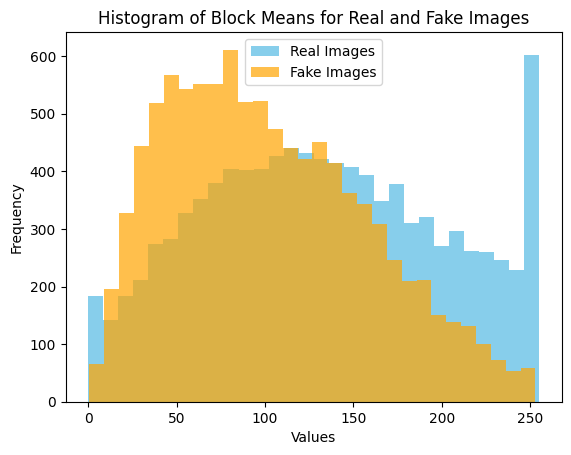

In [8]:
# Load the means, variances, and labels for fake and real images
fake_images_m,fake_images_v, fake_labels = load_imgs_from_directory(fake_dir, 0, num_images=num_images_to_load)
real_images_m,real_images_v, real_labels = load_imgs_from_directory(real_dir, 1, num_images=num_images_to_load)

for j in range(8): # Iterate through the first 8 blocks of real and fake images
    a=[i[j] for i in real_images_m] # Extract the j-th block from real images
    b=[i[j] for i in fake_images_m] # Extract the j-th block from fake images

    # Print mean and standard deviation statistics for the j-th block
    print("Mean of "+str(j+1)+"th block of real images :- " + str(np.mean(a)))
    print("Mean of "+str(j+1)+"th block of fake images :- " + str(np.mean(b)))
    print("Std of "+str(j+1)+"th block of real images :- " + str(np.std(a)))
    print("Std of "+str(j+1)+"th block of fake images :- " + str(np.std(b)))

# Plot histograms of the first block mean values for real and fake images
a=[i[0] for i in real_images_m]
b=[i[0] for i in fake_images_m]

plt.hist(x=a, bins=30, color='skyblue', label='Real Images')
plt.hist(x=b, bins=30, color='orange', alpha=0.7, label='Fake Images')  # Adding alpha for better overlap visualization

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Block Means for Real and Fake Images')
plt.legend()  # Adding legend to differentiate between real and fake images
plt.show()

In [9]:
def feature_vec(mean, var):
    a=[]
    # Iterate through the mean and variance lists simultaneously
    for i,j in zip(mean, var):
        b=[]
        # Combine the mean and variance for each block into a single vector
        for k,l in zip(i,j):
            b.append(k) # Append the mean value
            b.append(l)  # Append the variance value
        a.append(b) # Append the combined vector for the current image
    return a # Return the list of feature vectors

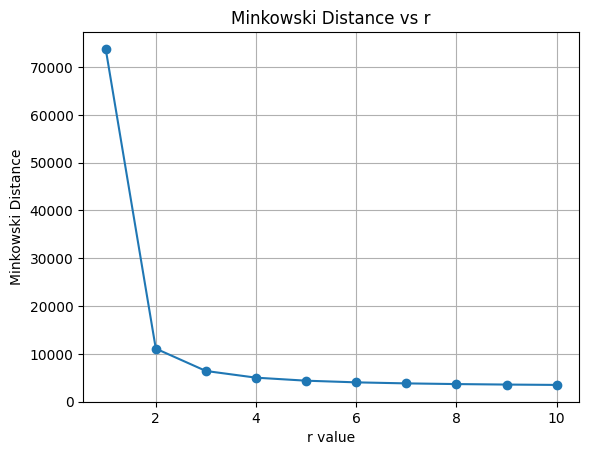

In [10]:
# Convert mean and variance features into feature vectors for real and fake images
real_feat_vec = feature_vec(real_images_m, real_images_v)
fake_feat_vec = feature_vec(fake_images_m, fake_images_v)

# Define a range of r values for the Minkowski distance calculation
r_values = range(1, 11)
# Calculate the Minkowski distance between the first feature vector of real and fake images for each r value
distances = [minkowski(real_feat_vec[0], fake_feat_vec[0], r) for r in r_values]

# Plot the Minkowski distance against r values
plt.plot(r_values, distances, marker='o')
plt.xlabel('r value')
plt.ylabel('Minkowski Distance')
plt.title('Minkowski Distance vs r')
plt.grid(True)
plt.show()

In [11]:
# Convert mean and variance features into feature vectors for real and fake images
features_real = feature_vec(real_images_m, real_images_v)
features_vec = feature_vec(fake_images_m, fake_images_v)

# Combine feature vectors and corresponding labels into a single dataset
features = np.vstack((features_real, features_vec))
labels = np.concatenate((fake_labels, real_labels))

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.5, random_state=5)

# Initialize and train the K-Nearest Neighbors classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

# Evaluate the classifier's accuracy on the test set
accuracy = knn.score(x_test, y_test)
print("Accuracy:", accuracy)

# Evaluate the classifier's accuracy on the training set
training_accuracy = knn.score(x_train, y_train)
print(f"Training Accuracy: {training_accuracy}")

# Predict the labels for the first 20 samples in the test set
predictions = knn.predict(x_test[:20])
actual_labels = y_test[:20]

# Create a DataFrame to compare predicted labels with actual labels
predicted_vs_actual = pd.DataFrame({"Actual": actual_labels, "Predicted": predictions})
predicted_vs_actual

Accuracy: 0.6635
Training Accuracy: 0.8299


,Actual,Predicted
0,1,1
1,0,1
2,0,1
3,0,0
4,1,1
5,0,0
6,0,0
7,0,1
8,0,0
9,0,0


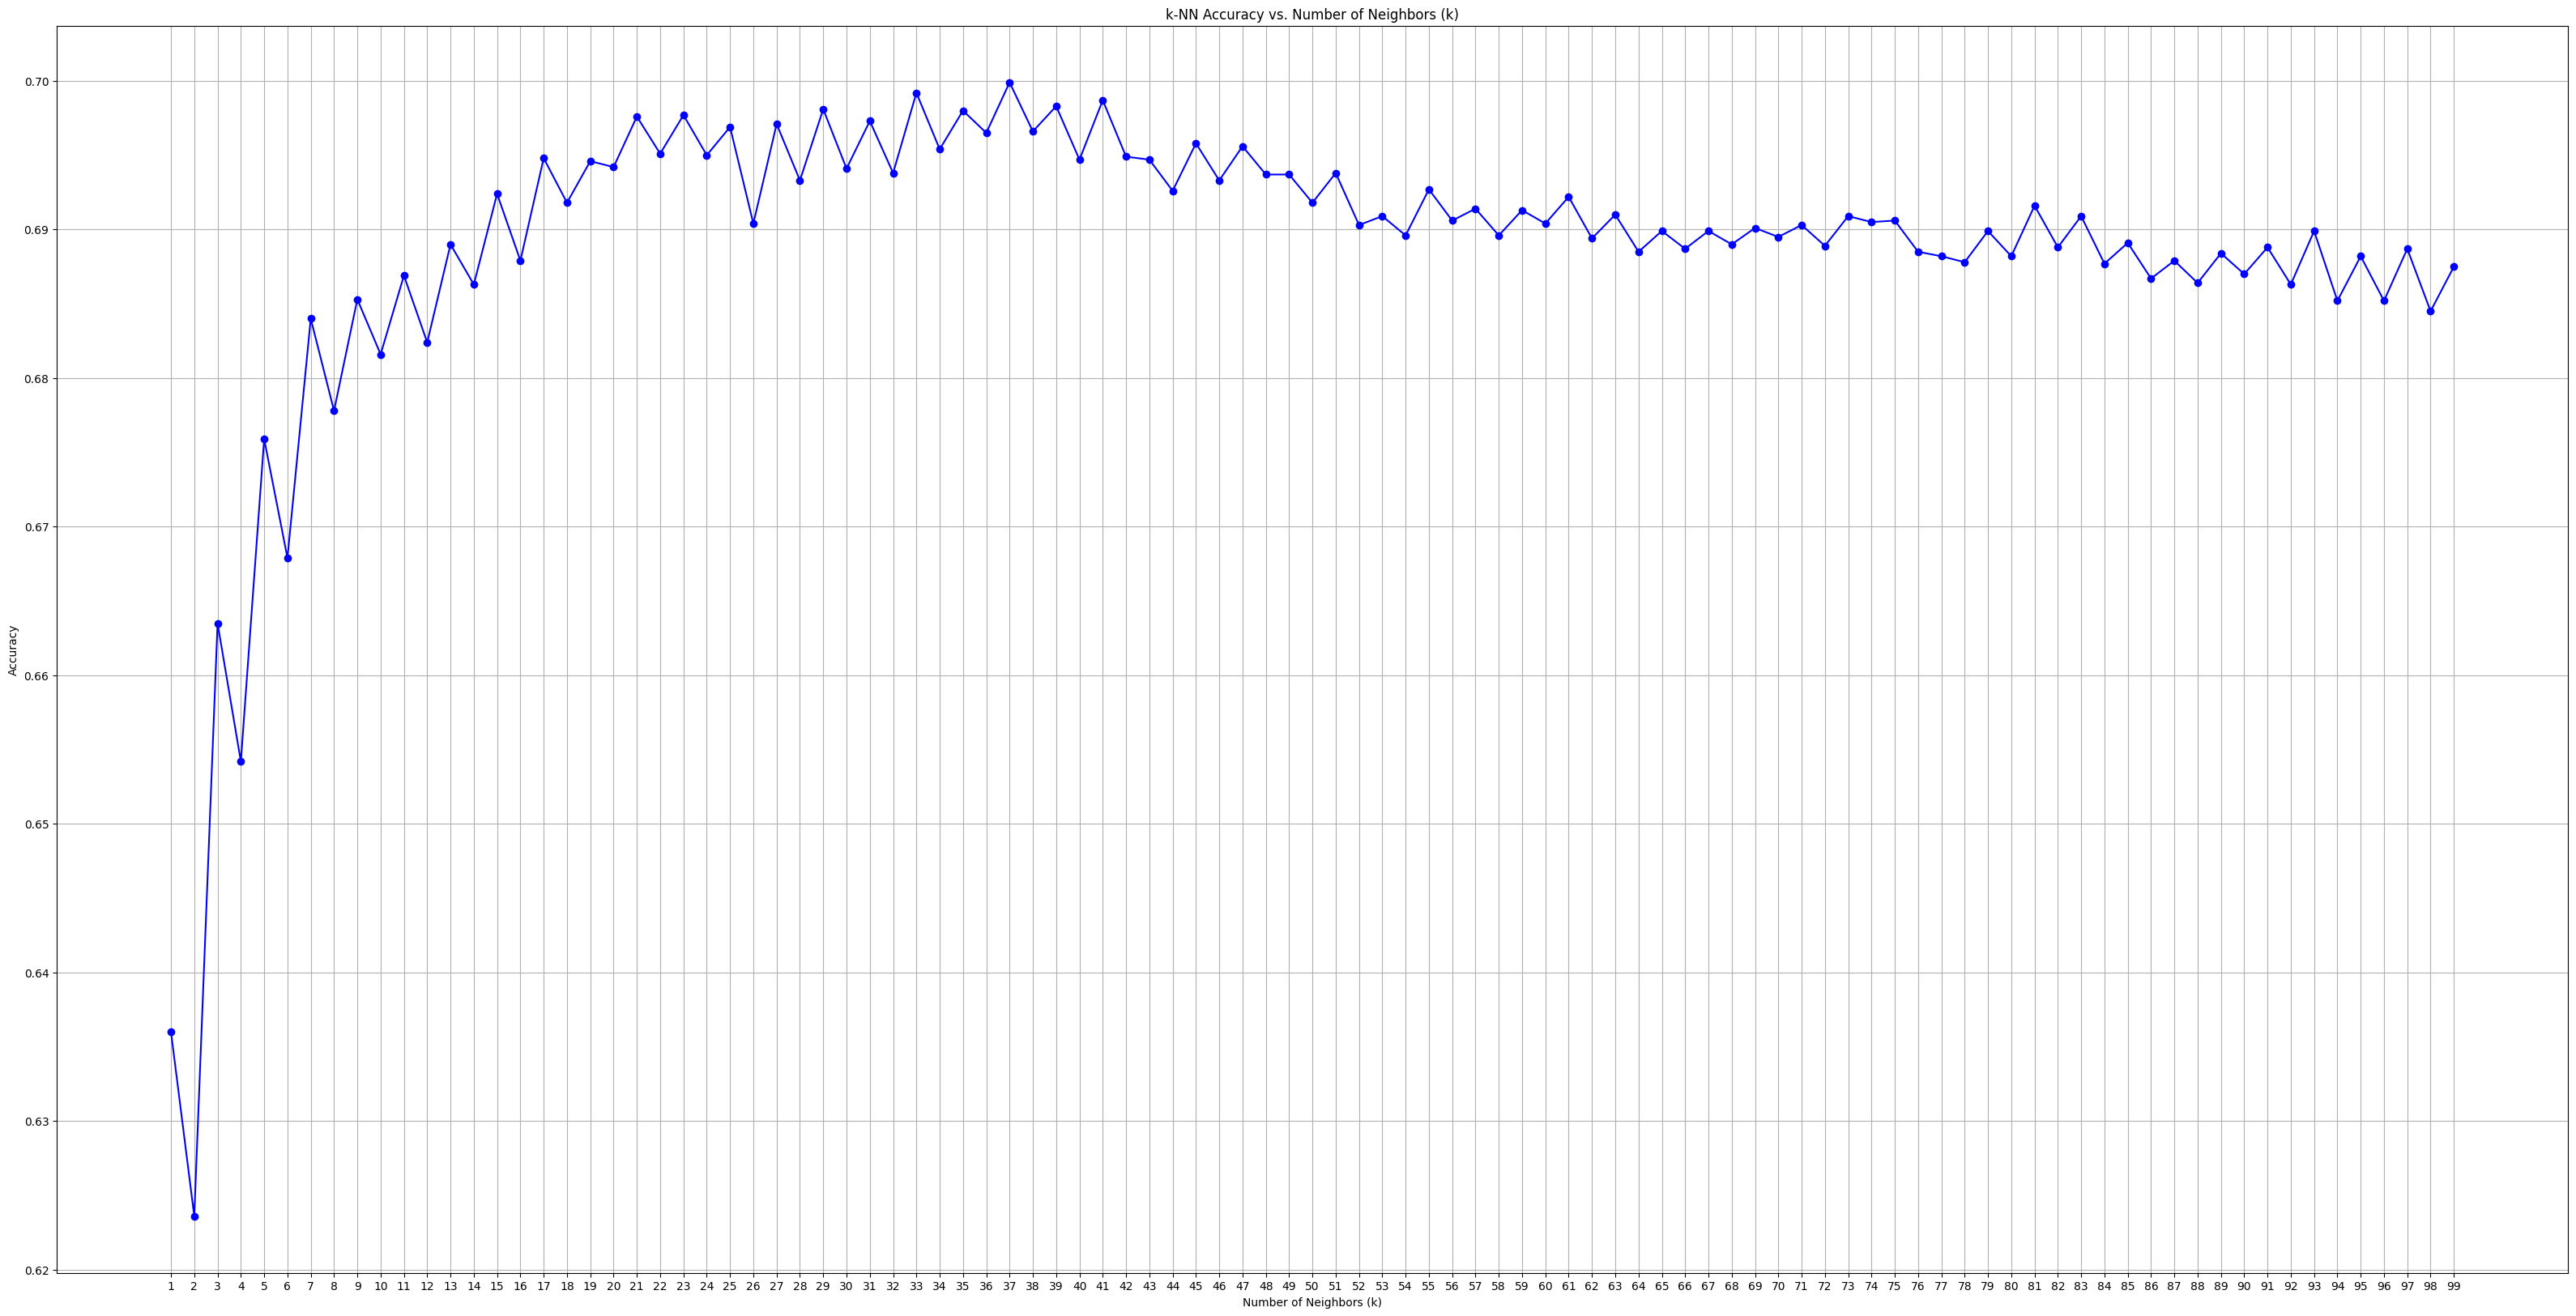

,K-Value,Accuracy
1,1,0.6360
2,2,0.6236
3,3,0.6635
4,4,0.6542
5,5,0.6759
...,...,...
95,95,0.6882
96,96,0.6852
97,97,0.6887
98,98,0.6845


In [12]:
k_values = range(1, 100)
accuracies = []                                   

# Iterate over a range of k values to determine the best number of neighbors for the k-NN classifier
for k in k_values:
    # Initialize the K-Nearest Neighbors classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)# Train the classifier
    y_pred = knn.predict(x_test)# Predict the labels for the test set
    testing_accuracy = accuracy_score(y_test, y_pred)# Calculate the accuracy of the classifier
    accuracies.append(testing_accuracy)# Append the accuracy to the list

# Create a DataFrame to store k values and corresponding accuracies            
accuracies_df = pd.DataFrame({"K-Value":k_values,"Accuracy": accuracies},index=k_values)

# Plot accuracy vs. number of neighbors (k)
plt.figure(figsize=(40,20))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('k-NN Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)

plt.grid(True)
plt.show()

# Display the DataFrame containing k values and accuracies
accuracies_df   

In [13]:
knn = KNeighborsClassifier(n_neighbors=10)# Initialize the K-Nearest Neighbors classifier with 10 neighbors
knn.fit(x_train, y_train)# Train the classifier on the training set
y_pred_train = knn.predict(x_train)# Predict the labels for the training set
y_pred = knn.predict(x_test)# Predict the labels for the test set

Confusion Matrix:
[[3994 1019]
 [2165 2822]]
Precision: 0.7347045040354074
Recall: 0.5658712652897534
F1 Score: 0.6393294064340734
Confusion Matrix (Training):
[[4279  708]
 [1845 3168]]
Training Precision: 0.8173374613003096
Training Recall: 0.6319569120287253
Training F1 Score: 0.7127910901113736


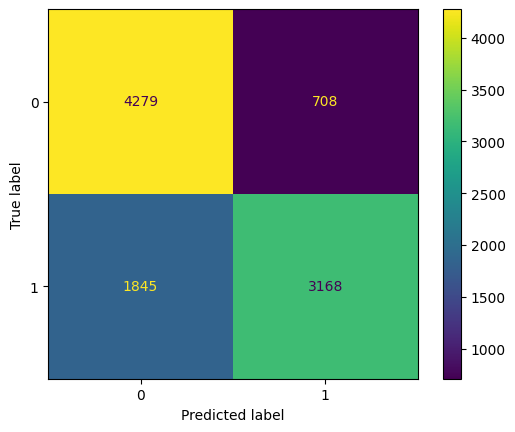

In [14]:
# Calculate the confusion matrix, precision, recall, and F1 score for the test set
conf_mat = confusion_matrix(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f_score = f1_score(y_test,y_pred)

print(f"Confusion Matrix:\n{conf_mat}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f_score}")



# Confusion matrix, precision, recall, and F1 score for the training set
conf_mat_train = confusion_matrix(y_train, y_pred_train)
ConfusionMatrixDisplay(conf_mat_train).plot()  # Displays the confusion matrix

# Calculate precision, recall, and F1 score for the training set
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f_score_train = f1_score(y_train, y_pred_train)

print(f"Confusion Matrix (Training):\n{conf_mat_train}")
print(f"Training Precision: {precision_train}")
print(f"Training Recall: {recall_train}")
print(f"Training F1 Score: {f_score_train}")

# Lists to store accuracies for different k values
accuracy_test=[]
accuracy_train=[]

# Iterate over a range of k values to determine the best number of neighbors for the k-NN classifier
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)

    # Predict the labels for both training and test sets
    y_pred_train = knn.predict(x_train)
    y_pred = knn.predict(x_test)

    # Calculate and store the accuracies for training and test sets
    testing_accuracy = accuracy_score(y_test, y_pred)
    training_accuracy = accuracy_score(y_train, y_pred_train)

    
    accuracy_test.append(testing_accuracy)
    accuracy_train.append(training_accuracy)



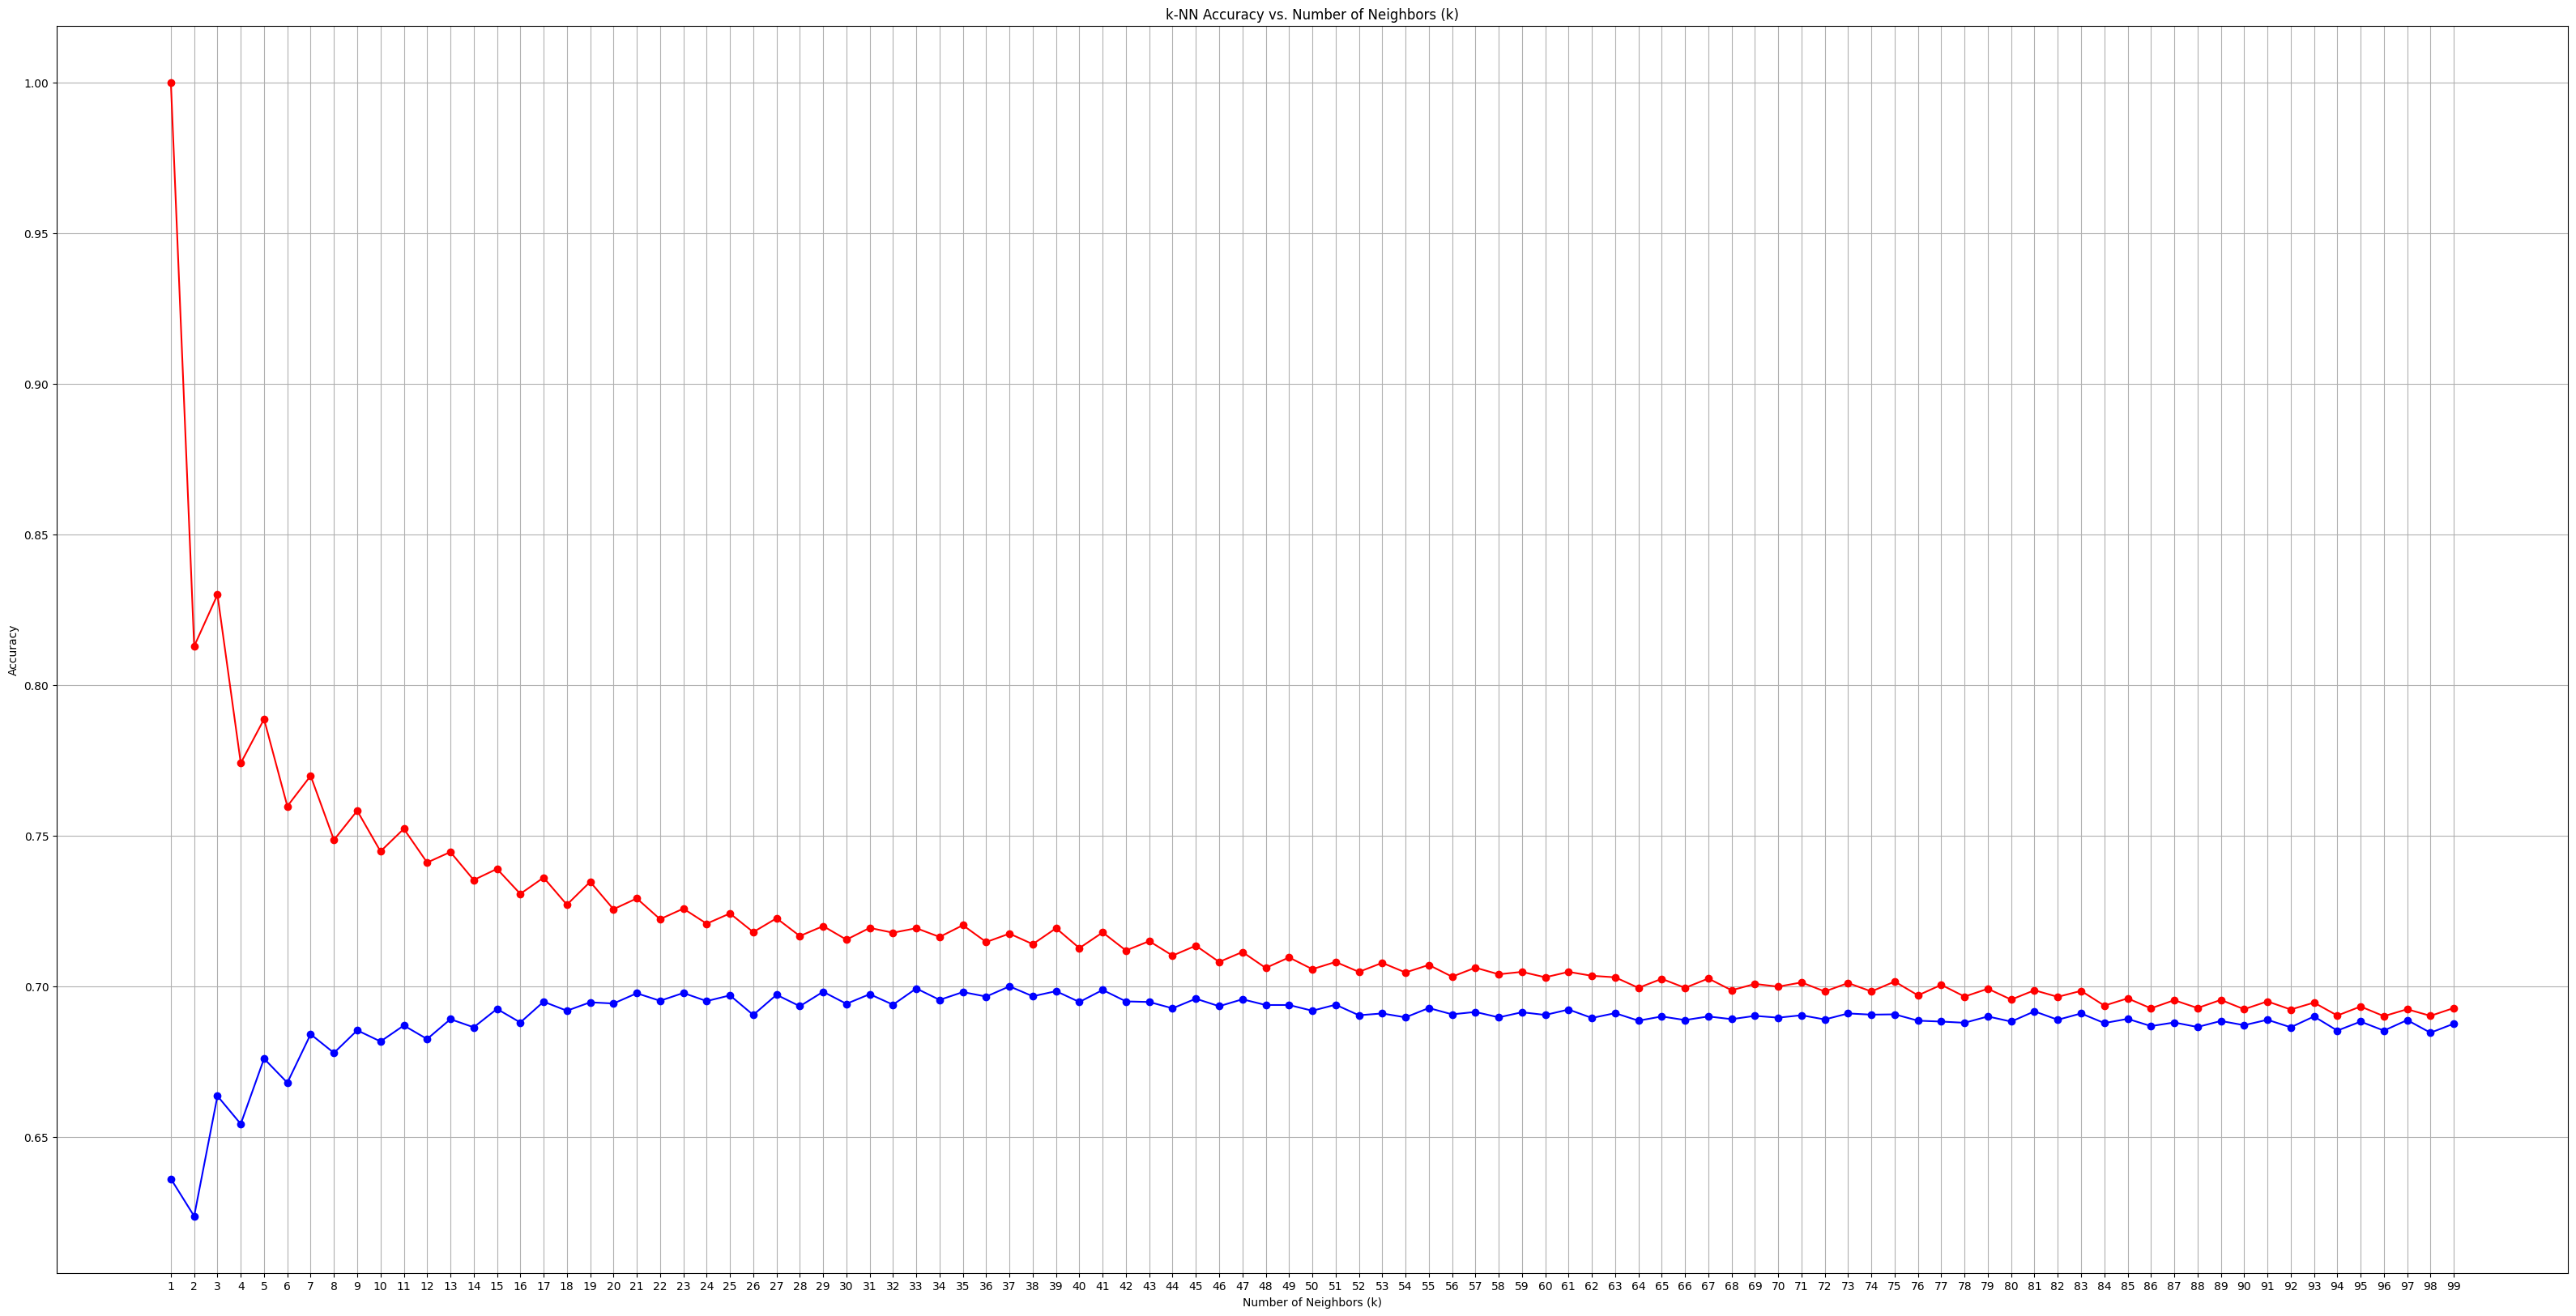

In [15]:
# Set the figure size for the plot
plt.figure(figsize=(40,20))

# Plot the accuracy for test and training sets against the number of neighbors (k)
plt.plot(k_values, accuracy_test, marker='o', linestyle='-', color='b')
plt.plot(k_values, accuracy_train, marker='o', linestyle='-', color='r')

# Set the title and labels for the plot
plt.title('k-NN Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)

plt.grid(True)# Enable grid for better readability
plt.show()

In [16]:
# Load the purchase data from the Excel file, specifying the sheet and columns to use
purchase_data = pd.read_excel("E:\zipp\college\Third Year\\5th Sem\ML\ML\Lab 2\Lab Session Data.xlsx", sheet_name='Purchase data', usecols='A:E')

# Extract columns 1 to 3 for matrix A (features) and column 4 for vector C (target values)
A = purchase_data.iloc[:, 1:4]
C = purchase_data.iloc[:, 4]

print("Dimensionality of the vector space:", purchase_data.shape)
print("Number of vectors:", purchase_data.shape[0])
print("Rank of matrix A:", np.linalg.matrix_rank(A))# rank of matrix A

# Compute the pseudo-inverse of matrix A
A_inv = np.linalg.pinv(A)

# Calculate the price of each item using the pseudo-inverse and target vector
price_of_each_item = (A_inv @ C)
print("Price of each item:", price_of_each_item)

# Calculate MSE, RMSE, MAPE and R2 scores for the price prediction
y = C
y_pred = A @ price_of_each_item

MSE = np.square(np.subtract(y,y_pred)).mean()# Calculate Mean Squared Error
RMSE = np.sqrt(MSE)# Calculate Root Mean Squared Error
MAPE = np.mean(np.abs((y - y_pred) / y)) * 100# Calculate Mean Absolute Percentage Error
R2 = 1 - (np.square(y - y_pred).sum() / np.square(y - y.mean()).sum())# Calculate R-squared score

print("MSE:", MSE)
print("RMSE:", RMSE)
print("MAPE:", MAPE)
print("R2:", R2)

Dimensionality of the vector space: (10, 5)
Number of vectors: 10
Rank of matrix A: 3
Price of each item: [ 1. 55. 18.]
MSE: 3.2311742677852644e-27
RMSE: 5.684341886080802e-14
MAPE: 2.0176081332685152e-14
R2: 1.0


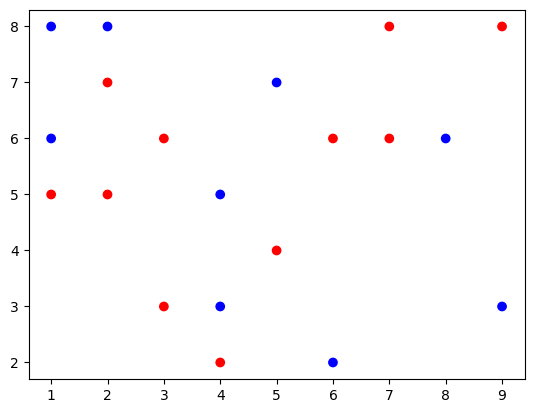

In [17]:
def generate_data(l, h, n, d):
    # Generate a range of x and y values based on the input parameters
    x_values = np.arange(l * 10**d, h * 10**d)
    y_values = np.arange(l * 10**d, h * 10**d)
    # Create a meshgrid of all possible (x, y) points and reshape it
    all_points = np.array(np.meshgrid(x_values, y_values)).T.reshape(-1, 2) / (10**d)
    np.random.shuffle(all_points)# Shuffle the points to randomize their order
    features = all_points[:n]# Select the first n points as features
    classes = np.random.randint(0, 2, (n, 1))  # Randomly assign classes (0 or 1) to the n points

    data = np.concatenate((features, classes), axis=1)# Combine the features and classes into a single dataset
    return pd.DataFrame(data, columns=['X', 'Y', 'Class'])# Return the data as a DataFrame

# Define a color map for plotting the classes
color_map = {0: 'red', 1: 'blue'}
train_df = generate_data(1, 10, 20, 0)# Generate a dataset with specified parameters

plt.scatter(train_df['X'], train_df['Y'], c=train_df['Class'].map(color_map))
plt.show()

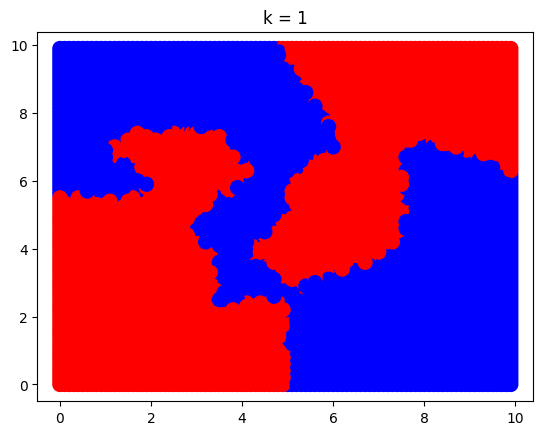

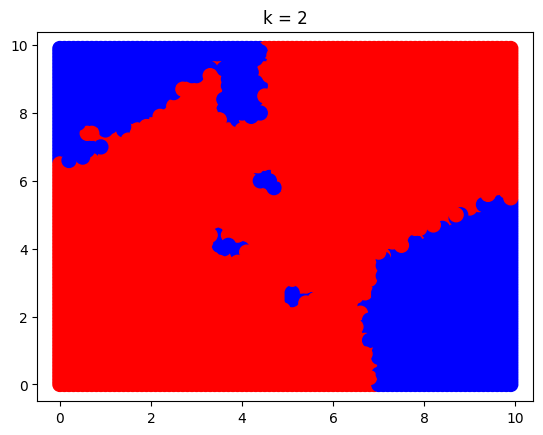

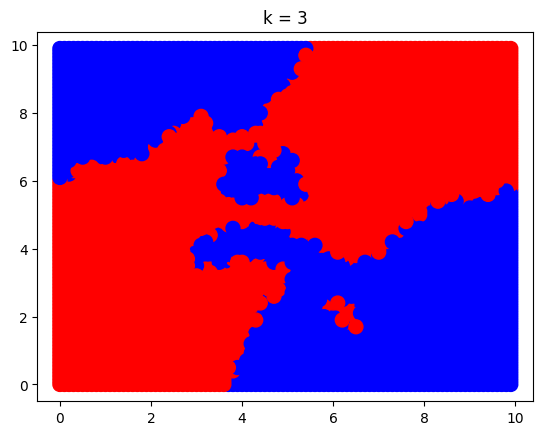

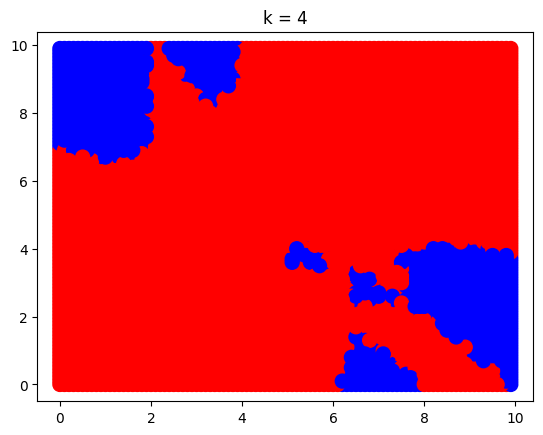

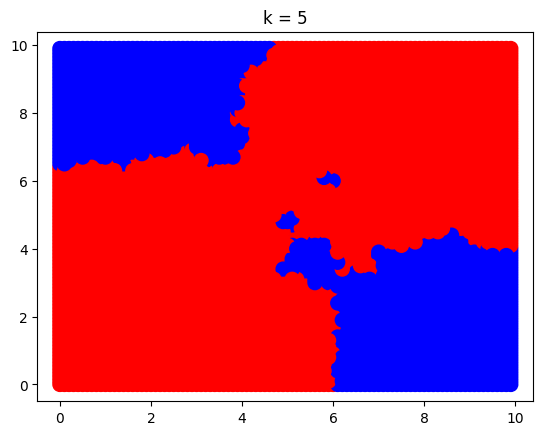

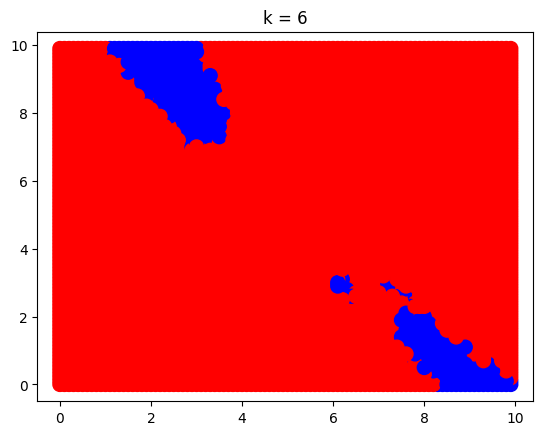

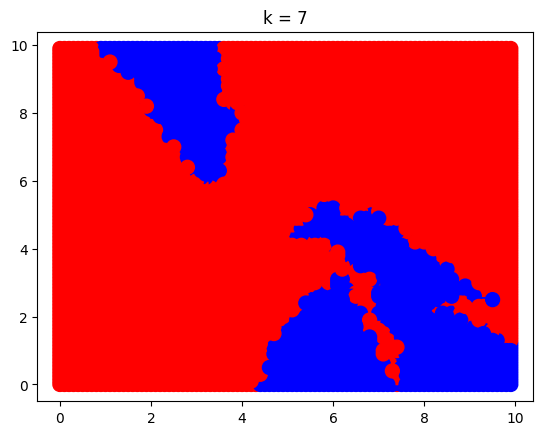

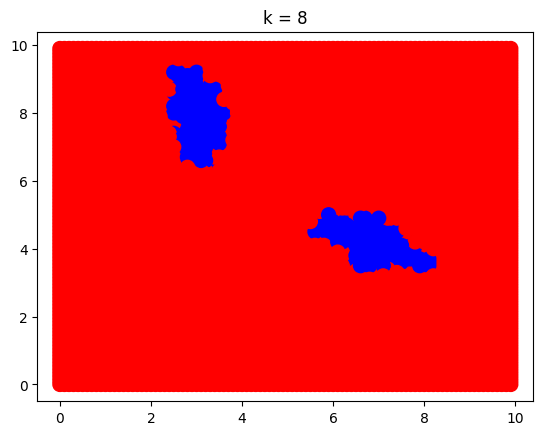

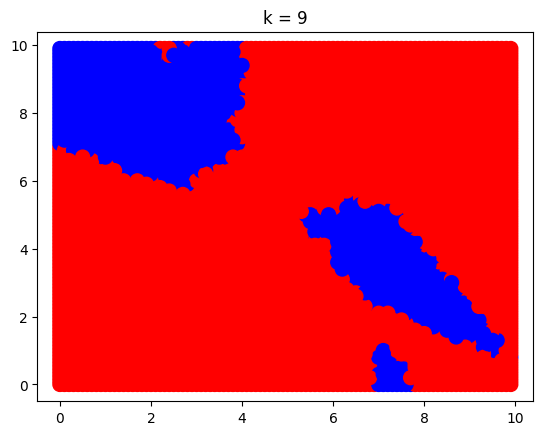

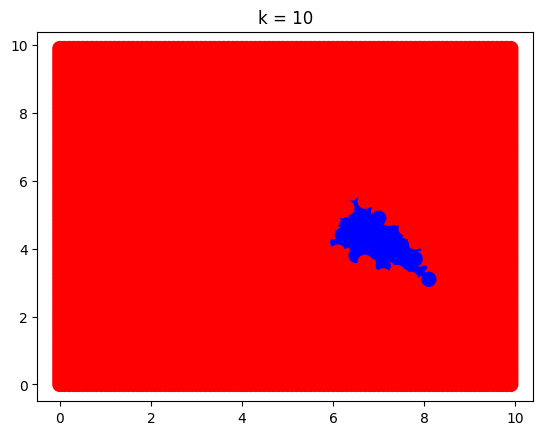

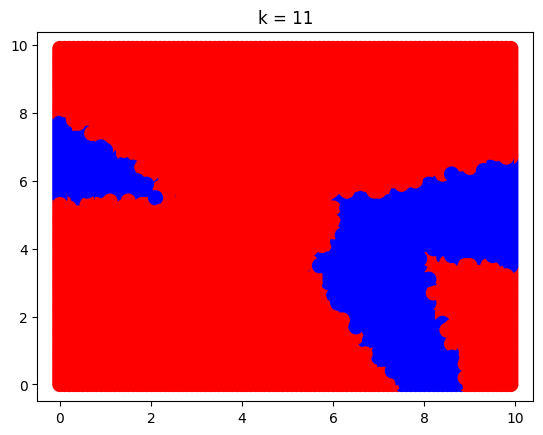

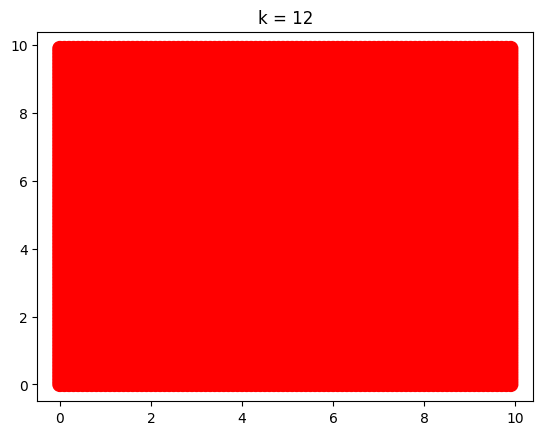

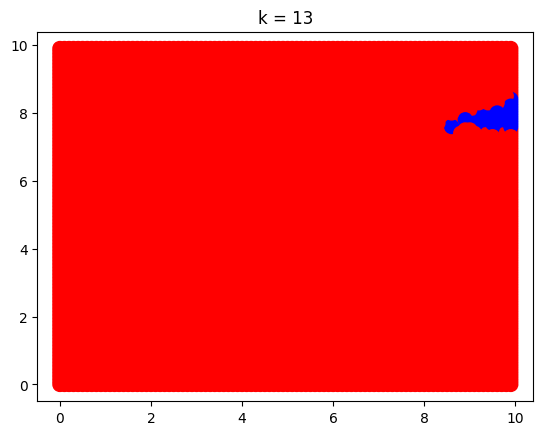

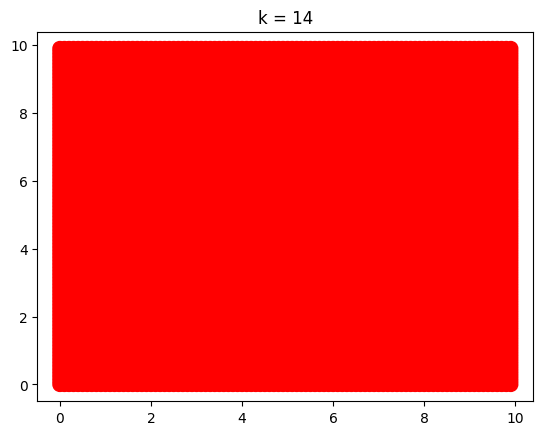

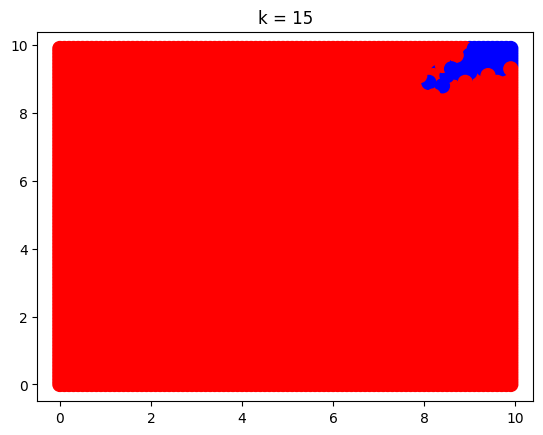

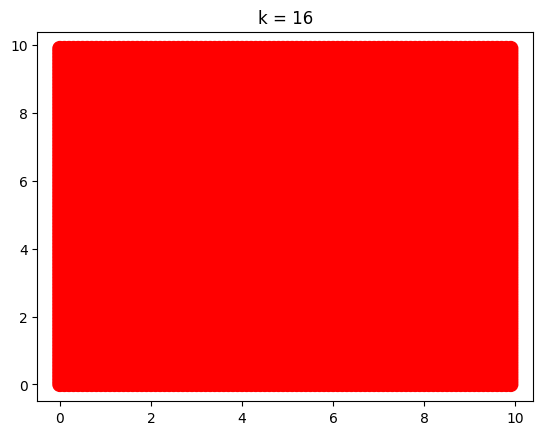

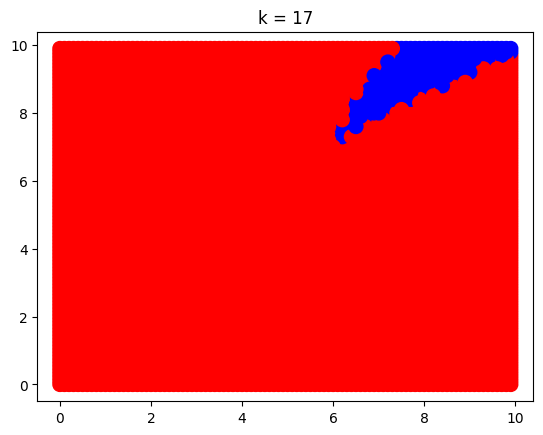

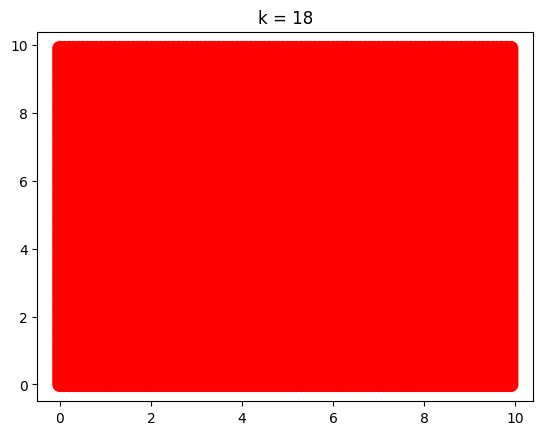

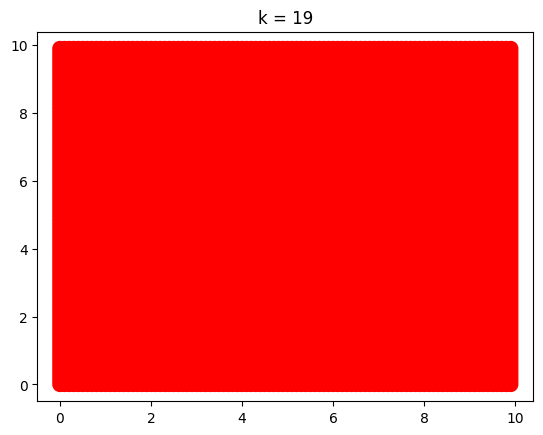

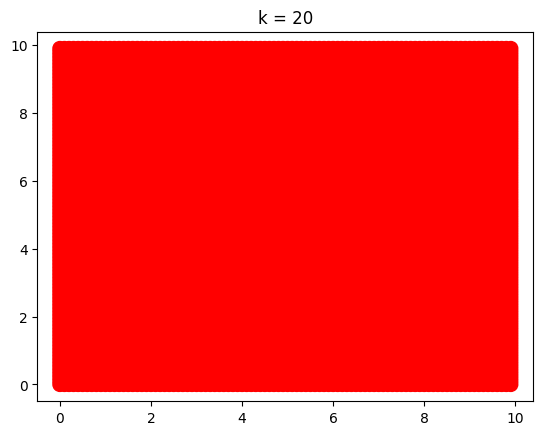

In [18]:
test_df = generate_data(0, 10, 10000, 1)# Generate a new test dataset with specified parameters

# Iterate through different values of k for k-NN
for i in range(20):
    # Initialize the K-Nearest Neighbors classifier with i+1 neighbors
    knn = KNeighborsClassifier(n_neighbors=i+1)
    knn.fit(train_df[['X', 'Y']], train_df['Class'])# Fit the classifier on the training dataset
    test_df['Class'] = knn.predict(test_df[['X', 'Y']])# Predict the classes for the test dataset
    plt.title(f'k = {i+1}')
    plt.scatter(test_df['X'], test_df['Y'], c=test_df['Class'].map(color_map), s=100)
    plt.show()

In [19]:

knn = KNeighborsClassifier()# Initialize the K-Nearest Neighbors classifier
# Define a dictionary with the parameter grid for the number of neighbors
params = {'n_neighbors': np.arange(1, 10),}

grid_search = GridSearchCV(knn, params)# Set up GridSearchCV to find the best k value
grid_search.fit(train_df[['X', 'Y']], train_df['Class'])# Fit the grid search on the training data

grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=2)